In [2]:
# import s3fs; import xarray as xr; import numpy as np
# import pandas as pd; import dask.array as da; import ocetrac
# import matplotlib.pyplot as plt; import cartopy.crs as ccrs
# import warnings; import expectexception
# warnings.filterwarnings('ignore')
# import netCDF4 as nc; import datetime as dt; import scipy
# import intake; import pprint
# # Allow multiple lines per cell to be displayed without print (default is just last line)
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# # Enable more explicit control of DataFrame display (e.g., to omit annoying line numbers)
# from IPython.display import HTML

In [3]:
# !pip install scikit-image==0.19.3
# del skimage
# import imp
import skimage
skimage.__version__

'0.19.3'

In [4]:
import importlib
import xarray as xr; import netCDF4 as nc; import h5netcdf; import numpy as np
from skimage.measure import regionprops
import matplotlib.pyplot as plt
# imp.reload(xr)

## ============================================================ below is something Valentina tried
# events = event_file
# for i in range(len(events.time)):
#     im = events.isel(time=0).SSTA.data
#     mask = xr.where(events.isel(time=i).SSTA>0, 1, 0).data
#     properties = regionprops(mask, im)
#     for prop in properties:
#         print(prop.centroid_weighted)

In [132]:
data_path = 'SSTA_and_events_0_3.nc'
event_file =  xr.open_dataset(data_path)
events = xr.open_dataset(data_path, chunks={'lat': -1, 'lon': -1, 'time': 20})

In [133]:
event_file

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    member_id  object ...
    quantile   float64 ...
    month      (time) int64 ...
Data variables:
    SSTA       (time, lat, lon) float64 ...
    labels     (time, lat, lon) float64 ...

In [134]:
events

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    member_id  object ...
    quantile   float64 ...
    month      (time) int64 dask.array<chunksize=(20,), meta=np.ndarray>
Data variables:
    SSTA       (time, lat, lon) float64 dask.array<chunksize=(20, 192, 288), meta=np.ndarray>
    labels     (time, lat, lon) float64 dask.array<chunksize=(20, 192, 288), meta=np.ndarray>

In [97]:
mhw_id = 36
timestep = 0

forOneMHW_onlylabels_timesteps = forOneMHW_labels_only(event_file, mhw_id)
forOneMHW_onlySSTA_timesteps = forOneMHW_SSTA_only(event_file, mhw_id)
forOneMHW_onlySSTA_timesteps.shape

(7, 192, 288)

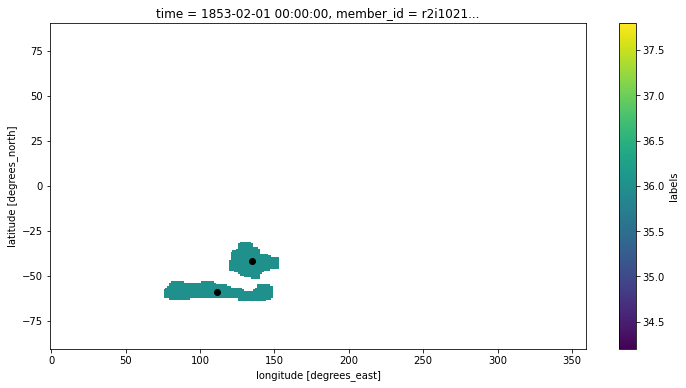

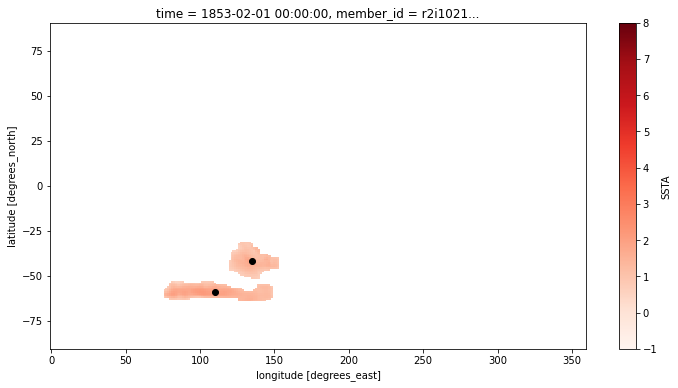

In [104]:
# calculate centroids
flat_centroid_list = centroids_per_timestep(forOneMHW_onlylabels_timesteps, timestep)
y_val = list(zip(*flat_centroid_list))[0]; x_val = list(zip(*flat_centroid_list))[1]
forOneMHW_onlylabels_timesteps[timestep,:,:].plot.imshow(); plt.scatter(x_val, y_val, c='k'); plt.show()

# calculate center of masses
center_of_mass_list = com_per_timestep(forOneMHW_onlylabels_timesteps, forOneMHW_onlySSTA_timesteps, timestep)
y_val = list(zip(*center_of_mass_list))[0]; x_val = list(zip(*center_of_mass_list))[1]
forOneMHW_onlySSTA_timesteps[timestep,:,:].plot.imshow(vmin=-1, vmax=8, cmap='Reds'); plt.scatter(x_val, y_val, c='k'); plt.show()

# displacement
centroid_list, center_of_mass_list, distance_cent_ls, distance_com_ls, centroid_xrcoords_ls, com_xrcoords_ls = displacement(forOneMHW_onlylabels_timesteps, forOneMHW_onlySSTA_timesteps)

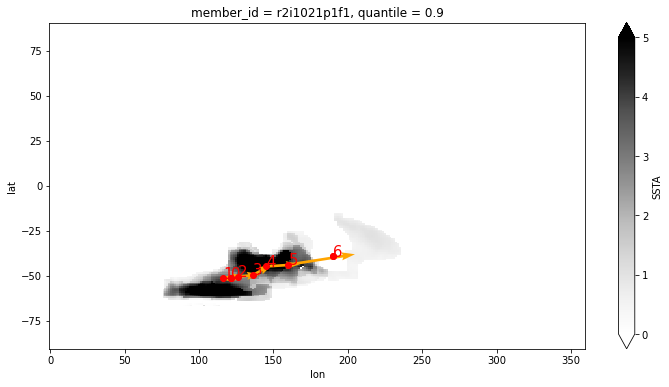

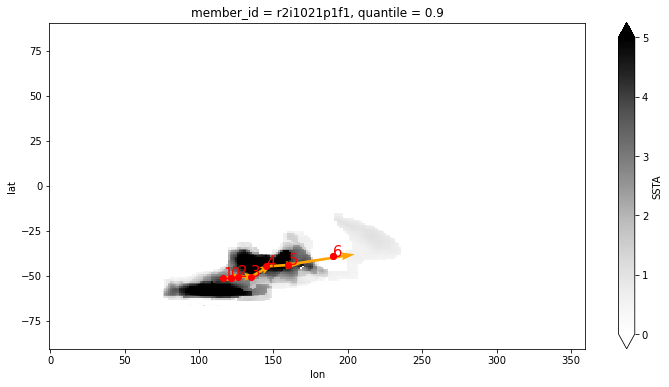

In [105]:
plot_displacement(com_xrcoords_ls, forOneMHW_onlySSTA_timesteps); plt.show()
plot_displacement(centroid_xrcoords_ls, forOneMHW_onlySSTA_timesteps); plt.show()

In [101]:
# functions
def number_of_mhws(event_file):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    return len(np.unique(event_file.labels)) - 1

def calc_duration(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    return len(event_file.where(event_file.labels==mhw_id, drop=True).time)

def calc_cumulativeintensity(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    cumulative_intensity = np.nansum(for_one_mhw.SSTA)
    cumulative_intensity_monthly = for_one_mhw.SSTA.sum(axis=(1,2)).values
    return cumulative_intensity, cumulative_intensity_monthly

def calc_meanintensity(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    mean_intensity = np.nanmean(for_one_mhw.SSTA)
    mean_intensity_monthly = for_one_mhw.SSTA.mean(axis=(1,2)).values
    return mean_intensity, mean_intensity_monthly

def calc_maximumintensity(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    max_intensity = np.nanmax(for_one_mhw.SSTA)
    max_intensity_monthly = for_one_mhw.SSTA.max(axis=(1,2)).values
    return max_intensity, max_intensity_monthly

def calc_stdintensity(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    std_intensity = np.nanstd(for_one_mhw.SSTA)
    std_intensity_monthly = for_one_mhw.SSTA.std(axis=(1,2)).values
    return std_intensity, std_intensity_monthly

def calc_spatialextent(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    spatial_extents = []
    coords_full = []
    for i in range(len(for_one_mhw.time)):
        for_onetimestep_stacked = for_one_mhw.labels[i,:,:].stack(zipcoords=['lat','lon'])
        intermed = for_onetimestep_stacked[for_onetimestep_stacked.notnull()].zipcoords.values
        lats = [x[0] for x in intermed]; lons = [x[1] for x in intermed]
        coords = list(zip(lats, lons))
        coords_full.append(coords)
        y,x=zip(*coords)
        dlon = [np.cos(y[c]*np.pi/180)*(111.320*1) for c in np.arange(0, len(coords))]; dlat = (110.574 *1) * np.ones(len(dlon))
        area = np.sum(dlon*dlat)
        spatial_extents.append(area)
    max_spatial_extent = np.max(spatial_extents)
    max_spatial_extent_time = np.argmax(spatial_extents)
    mean_spatial_extent = np.mean(spatial_extents)
    cumulative_spatial_extent = np.sum(spatial_extents)
    return coords_full, spatial_extents, max_spatial_extent, max_spatial_extent_time, mean_spatial_extent, cumulative_spatial_extent

def initialization(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
    first_timestep = mhw_when[0][0]
    bymonth = np.resize(np.arange(1,13),12*166)[1:-11]
    month = bymonth[first_timestep]
    return first_timestep, for_one_mhw.SSTA[first_timestep,:,:].values, month

from skimage.measure import find_contours
from haversine import haversine, Unit
from scipy.interpolate import interp1d

def calc_perimeter(event_file, mhw_id):
     '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    first_timestep, first_array, month = initialization(event_file, mhw_id)
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)

    convert_long_range = interp1d([0,360],[-180,180])
    perimeter_ls = []
    for i in timesteps_to_choose_from:
        bw = for_one_mhw.labels[i,:,:].values > 0
        contours = find_contours(bw)
        distance_ls = []
        for contour_num in range(len(contours)):
            latitudes = for_one_mhw.lat.values[contours[contour_num][:,0].astype(int)]
            longitudes = for_one_mhw.lon.values[contours[contour_num][:,1].astype(int)]    
            coords = list(zip(latitudes, convert_long_range(longitudes)))

            for i in range(len(coords)-1):
                distance = haversine(coords[i], coords[i+1],Unit.KILOMETERS)
                distance_ls.append(distance)
            distance_ls.append(haversine(coords[len(coords)-1], coords[0],Unit.KILOMETERS))
        perimeter = np.sum(distance_ls)
        perimeter_ls.append(perimeter)
    return perimeter_ls  

def calc_percperimetervsarea(spatial_extents, perimeters):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    return (np.asarray(perimeters)/np.asarray(spatial_extents))*100

def convert_from_timeres_to_months(time_step):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    bymonth = np.resize(np.arange(1,13),12*166)[1:-11]
    month = bymonth[first_timestep]
    return month

def calc_compltodeform(coords_full, spatial_extents):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    perc_sharedarea_ls = []
    for i in range(len(coords_full)-1):
        a_set = set(coords_full[i])
        b_set = set(coords_full[i+1])
        if a_set & b_set:
            coords = a_set & b_set
            y,x=zip(*coords)
            dlon = [np.cos(y[c]*np.pi/180)*(111.320*1) for c in np.arange(0, len(coords))]; dlat = (110.574 *1) * np.ones(len(dlon))
            sharedarea = np.sum(dlon*dlat)
            perc_sharedarea_ls.append((sharedarea/ (spatial_extents[i] + spatial_extents[i+1]))*100)
        else:
            sharedareaarea = 0
            perc_sharedarea_ls.append((sharedarea/ (spatial_extents[i] + spatial_extents[i+1]))*100)
    return perc_sharedarea_ls

def calc_deform(perc_sharedarea_ls):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    return np.asarray(100 - np.asarray(perc_sharedarea_ls))

def calc_whenlargesmall(spatial_extents):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    when_large = (np.argmax(spatial_extents) / len(spatial_extents))*100
    when_small = (np.argmin(spatial_extents) / len(spatial_extents))*100
    return when_large, when_small

def cross_correlation_spat(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    first_timestep, first_array, month = initialization(event_file, mhw_id)
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)
    cc_image_array = np.zeros((len(timesteps_to_choose_from), 192,288))    
    for i in range(len(timesteps_to_choose_from[:-1])):
        image = for_one_mhw.SSTA[timesteps_to_choose_from[i],:,:].values
        image = np.nan_to_num(image)
        offset_image = for_one_mhw.SSTA[timesteps_to_choose_from[i+1],:,:].values
        offset_image = np.nan_to_num(offset_image)
        image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
        cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
        cc_image_array[i,:,:] = np.real(cc_image)
    return cc_image_array

from skimage.morphology import convex_hull_image
from skimage import img_as_float

def perc_imoverchull(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    perc_imoverchull_ls = []
    for i in range(len(for_one_mhw.time)):
        image = for_one_mhw.labels[i].values
        image = [image == mhw_id][0]
        chull = convex_hull_image(image)
        chull_asflt = img_as_float(chull.copy())
        image_asflt = img_as_float(image.copy())
        perc_imoverchull = np.sum(image_asflt)/np.sum(chull_asflt)*100
        perc_imoverchull_ls.append(perc_imoverchull)
    return perc_imoverchull_ls

from skimage.measure import label as label_np, regionprops

def _get_labels(binary_images):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    '''label binary images at each time step using skimage.measure.label'''
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels

def _get_centroids(sub_labels):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    '''find the centroids of objects assigned to each unique label using
    skimage.measure.regionprops'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values),
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    for i in range(0,len(centroids)):
        if centroids[i][1] >= 359.75:
            centroids[i] = (centroids[i][0], list(centroids[i])[1] - 359.75)
    return centroids

def forOneMHW_labels_only(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
    first_timestep = mhw_when[0][0]
    duration = calc_duration(event_file, mhw_id)
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)
    forOneMHW_only_timesteps = for_one_mhw.labels[timesteps_to_choose_from,:,:]
    return forOneMHW_only_timesteps

def forOneMHW_SSTA_only(event_file, mhw_id):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
    first_timestep = mhw_when[0][0]
    duration = calc_duration(event_file, mhw_id)
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)
    forOneMHW_only_timesteps = for_one_mhw.SSTA[timesteps_to_choose_from,:,:]
    return forOneMHW_only_timesteps

def centroids_per_timestep(forOneMHW_onlylabels_timesteps, timestep):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    # Step 1. We start with one timestep and get all the sublabels
    timestep_of_interest = forOneMHW_onlylabels_timesteps[timestep,:,:]
    get_sub_lbs = timestep_of_interest
    sub_labels = _get_labels(get_sub_lbs)
    sub_labels = xr.DataArray(sub_labels, dims=get_sub_lbs.dims, coords=get_sub_lbs.coords)
    sub_labels = sub_labels.where(timestep_of_interest>0, drop=False, other=np.nan)

    # Step 2. We get all the labels on the edges
    edge_right_sub_labels_ = sub_labels[:,-1:]
    edge_right_sub_labels = np.unique(np.unique(edge_right_sub_labels_)[~np.isnan(np.unique(edge_right_sub_labels_))])
    edge_left_sub_labels_ = sub_labels[:,:1]
    edge_left_sub_labels = np.unique(np.unique(edge_left_sub_labels_)[~np.isnan(np.unique(edge_left_sub_labels_))])
    
    edge_labels = np.unique(np.concatenate((edge_right_sub_labels, edge_left_sub_labels)))
    nonedgecases = np.setdiff1d(np.unique(sub_labels), edge_labels)
    nonedgecases = np.unique(nonedgecases[~np.isnan(nonedgecases)])

    centroid_list = []
    for i in nonedgecases:
        sub_labels_nonedgecases = sub_labels.where(sub_labels==i, drop=False, other=np.nan)
        centroid_list.append(_get_centroids(sub_labels_nonedgecases))
    for i in edge_left_sub_labels:
        sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
        lon_edge = sub_labels_left[:,-1:].lon.item()
        sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
        for j in edge_right_sub_labels:
            sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
            east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
            append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
            append_east_binarized = xr.where(append_east > 0, 1, np.nan)
            sub_labels = _get_labels(append_east_binarized)
            sub_labels = xr.DataArray(sub_labels, dims=append_east_binarized.dims, coords=append_east_binarized.coords)
            sub_labels = sub_labels.where(append_east_binarized>0, drop=False, other=np.nan)
            centroid_list.append(_get_centroids(sub_labels))
    flat_centroid_list = list(set([item for sublist in centroid_list for item in sublist]))
    # y_val = list(zip(*flat_centroid_list))[0]; x_val = list(zip(*flat_centroid_list))[1]
    return flat_centroid_list

def _get_center_of_mass(intensity_image):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    img = intensity_image.fillna(0)
    com = ndimage.center_of_mass(img.data)
    # centroid_list.append((float(img.lat[round(ndimage.com[0])].values),float(img.lon[round(ndimage.center_of_mass(img.data)[1])].values)))
    # props = regionprops(sub_labels, intensity, )
    w_centroids = [(float(img.lat[round(com[0])].values),
                  float(img.lon[round(com[1])].values))]
    for i in range(0,len(w_centroids)):
        if w_centroids[i][1] >= 359.75:
            w_centroids[i] = (w_centroids[i][0], list(w_centroids[i])[1] - 359.75)
    return w_centroids

from scipy import ndimage

def com_per_timestep(forOneMHW_onlylabels_timesteps, forOneMHW_onlySSTA_timesteps, timestep):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    timestep_of_interest = forOneMHW_onlylabels_timesteps[timestep,:,:] # labels in one given timestep
    SSTA_in_timestep = forOneMHW_onlySSTA_timesteps[timestep,:,:] # SSTA in one given timestep

    sub_labels = _get_labels(timestep_of_interest) # use skimage to get sub_labels
    sub_labels = xr.DataArray(sub_labels, dims=timestep_of_interest.dims, coords=timestep_of_interest.coords)
    sub_labels = sub_labels.where(timestep_of_interest>0, drop=False, other=np.nan)
    
    edge_right_sub_labels = np.unique(np.unique(sub_labels[:,-1:])[~np.isnan(np.unique(sub_labels[:,-1:]))])
    edge_left_sub_labels = np.unique(np.unique(sub_labels[:,:1])[~np.isnan(np.unique(sub_labels[:,:1]))])
    edge_labels = np.unique(np.concatenate((edge_right_sub_labels, edge_left_sub_labels)))
    nonedgecases = np.setdiff1d(np.unique(sub_labels), edge_labels)
    nonedgecases = np.unique(nonedgecases[~np.isnan(nonedgecases)])
    
    centroid_list = []
    for i in nonedgecases:
        sub_labels_nonedgecases = xr.where(sub_labels==i, SSTA_in_timestep, np.nan)
        sub_labels_nonedgecases_labels = sub_labels.where(sub_labels==i, drop=False, other=np.nan)
        centroid_list.append(_get_center_of_mass(sub_labels_nonedgecases)[0])
    for i in edge_left_sub_labels:
        sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
        lon_edge = sub_labels_left[:,-1:].lon.item()
        if lon_edge < 358.75:
            SSTA_left = SSTA_in_timestep.where((SSTA_in_timestep.lon <= lon_edge), drop=True)
            sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
            SSTA_left.coords['lon'] = (SSTA_left.coords['lon'] + 360) 
            for j in edge_right_sub_labels:
                sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
                sub_SSTAs_right = SSTA_in_timestep.where(sub_labels==j, drop=False, other=np.nan)
                east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
                east_SSTA = sub_SSTAs_right.where(sub_SSTAs_right.lon > lon_edge, drop=True)
                append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
                append_east_SSTA = xr.concat([east_SSTA.where(east_SSTA.lon >= lon_edge, drop=True), SSTA_left], dim="lon")
                append_east = xr.where(append_east > 0, 1.0, np.nan)
                centroid_list.append(_get_center_of_mass(append_east_SSTA)[0])
    return centroid_list

def displacement(forOneMHW_onlylabels_timesteps, forOneMHW_onlySSTA_timesteps):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    Will only work with we have more than 1 timestep
    centroid and center of mass displacement (one centroid per timestep)
    '''
    centroid_list = []; centroid_xrcoords_ls = []
    center_of_mass_list = []; com_xrcoords_ls = []
    for i in range(forOneMHW_onlylabels_timesteps.shape[0]):
        forOneMHW_onlylabels_timesteps = xr.where(forOneMHW_onlylabels_timesteps > 0, 1, np.nan)
        forOneMHW_onlySSTA_timesteps = xr.where(forOneMHW_onlySSTA_timesteps > 0, 1, np.nan)
        img_cent_xr_coords = _get_center_of_mass(forOneMHW_onlylabels_timesteps[i,:,:])
        centroid_xrcoords_ls.append(img_cent_xr_coords[0])
        img_SSTA_xr_coords = _get_center_of_mass(forOneMHW_onlySSTA_timesteps[i,:,:])
        com_xrcoords_ls.append(img_SSTA_xr_coords[0])
        img_cent = forOneMHW_onlylabels_timesteps[i,:,:].fillna(0)
        img_SSTA = forOneMHW_onlySSTA_timesteps[i,:,:].fillna(0)
        centroid_list.append(ndimage.center_of_mass(img_cent.data))
        center_of_mass_list.append(ndimage.center_of_mass(img_SSTA.data))

    y_val_cent = list(zip(*centroid_list))[0]; x_val_cent = list(zip(*centroid_list))[1]
    y_val_com = list(zip(*center_of_mass_list))[0]; x_val_com = list(zip(*center_of_mass_list))[1]

    convert_long_range = interp1d([0,360],[-180,180]); convert_lat_range = interp1d([0,180],[-90,90])

    coords_cent = list(zip(convert_lat_range(x_val_cent), convert_long_range(y_val_cent)))
    coords_com = list(zip(convert_lat_range(x_val_com), convert_long_range(y_val_com)))

    distance_cent_ls = []; distance_com_ls = []
    for i in range(len(coords_cent)-1):
        distance_cent = haversine(coords_cent[i], coords_cent[i+1],Unit.KILOMETERS)
        distance_cent_ls.append(distance_cent)
        distance_com = haversine(coords_com[i], coords_com[i+1],Unit.KILOMETERS)
        distance_com_ls.append(distance_com)
    return centroid_list, center_of_mass_list, distance_cent_ls, distance_com_ls, centroid_xrcoords_ls, com_xrcoords_ls

In [102]:
# Plotter function
def plot_displacement(coordinate_list, intensity_array):
    '''
    Description and Notes
    ----------
    
    Parameters
    ----------

    Returns
    -------
    
    '''
    summed_over_all_timesteps = intensity_array.sum(axis=0)
    summed_over_all_timesteps = xr.where(summed_over_all_timesteps == 0., np.nan, summed_over_all_timesteps)
    
    y_val_cent = list(zip(*coordinate_list))[0]; x_val_cent = list(zip(*coordinate_list))[1]
    x = x_val_cent; dx = [j-i for i, j in zip(x[:-1], x[1:])]
    y = y_val_cent; dy = [j-i for i, j in zip(y[:-1], y[1:])]

    plt.rcParams["figure.figsize"] = (12,6)
    summed_over_all_timesteps.plot.imshow(cmap='Greys',vmin=0,vmax=5)
    plt.quiver(x[:len(x)-1],y[:len(x)-1], dx,dy, width=0.005, color='Orange')
    for i in range(len(x)):
        plt.text(x[i],y[i],i, fontsize=15,c='Red')
        plt.scatter(x[i],y[i], c='Red')
    plt.scatter(x_val_cent[0], y_val_cent[0],c='Red'); plt.scatter(x_val_cent[-1], y_val_cent[-1],c='Red')
    # ax = plt.axes()
    # for i in range(len(x)):
    #     # ax.arrow(x[i], y[i], dx[i], dy[i], head_width=4, head_length=3, fc='yellow', ec='k')
    #     plt.text(x[i],y[i],i, fontsize=10)
    # summed_over_all_timesteps.plot.imshow(cmap='Reds',vmin=0,vmax=5)
    # plt.scatter(x,y)
    # plt.scatter(x_val_cent[0], y_val_cent[0],c='k'); plt.scatter(x_val_cent[-1], y_val_cent[-1],c='k')

#### Thoughts
- metrics between two heatwaves
    - at least between timestamps
    - average displacement per month
- metrics per heatwave

#### To do
- Center of mass function does not run with dask array